# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   cha         1206 non-null   int64 
 1   reflex      1206 non-null   int64 
 2   ac          1206 non-null   int64 
 3   focus       1206 non-null   int32 
 4   con         1206 non-null   int64 
 5   book        1206 non-null   object
 6   will        1206 non-null   int64 
 7   hp          1206 non-null   int64 
 8   fortitude   1206 non-null   int64 
 9   int         1206 non-null   int64 
 10  str         1206 non-null   int64 
 11  perception  1206 non-null   int64 
 12  wis         1206 non-null   int64 
 13  level       1206 non-null   int64 
 14  dex         1206 non-null   int64 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,cha,reflex,ac,focus,con,book,will,hp,fortitude,int,str,perception,wis,level,dex
0,1,19,29,1,5,Pathfinder Bestiary,17,215,22,1,7,20,2,10,2
1,1,14,28,0,5,Pathfinder Bestiary,16,220,21,-4,9,16,2,10,0
2,-2,17,25,0,6,Pathfinder Bestiary,15,175,20,-4,7,17,3,8,3
3,6,29,41,1,5,Pathfinder Bestiary,32,315,30,6,7,30,5,17,4
4,1,10,16,1,1,Pathfinder Bestiary,4,20,6,-1,-5,6,1,1,3


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


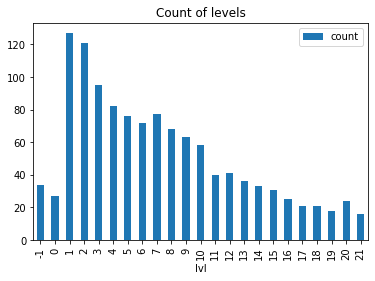

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.51
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "expanded", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

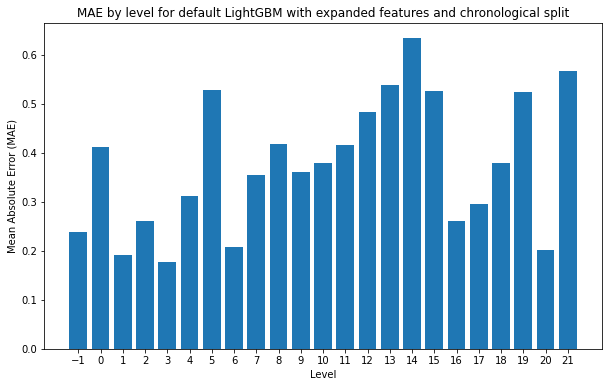

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and chronological split",
)

In [19]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.51

Round type: round
RMSE: 0.55

Round type: 0.33
RMSE: 0.54

Round type: 0.45
RMSE: 0.54



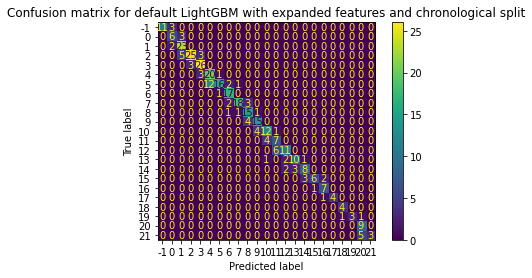

In [20]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with expanded features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 12:38:43,641] A new study created in memory with name: no-name-4f356cbf-6e00-42d3-85f0-b812f7878129
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.176175 + 0.0328765
[200]	cv_agg's l2: 0.173279 + 0.0328762
[300]	cv_agg's l2: 0.173594 + 0.0335765
Early stopping, best iteration is:
[222]	cv_agg's l2: 0.172715 + 0.0332841


feature_fraction, val_score: 0.172715:  14%|######4                                      | 1/7 [00:03<00:18,  3.03s/it]

[100]	cv_agg's l2: 0.171084 + 0.0371662
[200]	cv_agg's l2: 0.16819 + 0.0372176
[300]	cv_agg's l2: 0.168291 + 0.0360636


feature_fraction, val_score: 0.167977:  29%|############8                                | 2/7 [00:06<00:16,  3.35s/it]

Early stopping, best iteration is:
[284]	cv_agg's l2: 0.167977 + 0.0362729
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


feature_fraction, val_score: 0.159167:  43%|###################2                         | 3/7 [00:09<00:11,  2.97s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.188025 + 0.0387075
[200]	cv_agg's l2: 0.185962 + 0.0366348


feature_fraction, val_score: 0.159167:  57%|#########################7                   | 4/7 [00:11<00:08,  2.76s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.16417 + 0.0269033
[200]	cv_agg's l2: 0.161754 + 0.0277395


feature_fraction, val_score: 0.159167:  71%|################################1            | 5/7 [00:13<00:05,  2.63s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.175944 + 0.0325711
[200]	cv_agg's l2: 0.174411 + 0.0317661


feature_fraction, val_score: 0.159167:  86%|######################################5      | 6/7 [00:16<00:02,  2.52s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.166436 + 0.0264855
[200]	cv_agg's l2: 0.164316 + 0.0259177


feature_fraction, val_score: 0.159167: 100%|#############################################| 7/7 [00:18<00:00,  2.63s/it]


Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033


num_leaves, val_score: 0.159167:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:   5%|##5                                               | 1/20 [00:02<00:42,  2.26s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.18864 + 0.0314276
[200]	cv_agg's l2: 0.174505 + 0.0238814


num_leaves, val_score: 0.159167:  10%|#####                                             | 2/20 [00:03<00:26,  1.45s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  15%|#######5                                          | 3/20 [00:05<00:31,  1.84s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  20%|##########                                        | 4/20 [00:07<00:33,  2.09s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  25%|############5                                     | 5/20 [00:10<00:33,  2.21s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  30%|###############                                   | 6/20 [00:12<00:32,  2.29s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  35%|#################5                                | 7/20 [00:15<00:30,  2.32s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  40%|####################                              | 8/20 [00:17<00:27,  2.33s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  45%|######################5                           | 9/20 [00:20<00:26,  2.39s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  50%|########################5                        | 10/20 [00:22<00:24,  2.42s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  55%|##########################9                      | 11/20 [00:24<00:21,  2.37s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  60%|#############################4                   | 12/20 [00:27<00:19,  2.40s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  65%|###############################8                 | 13/20 [00:29<00:17,  2.47s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.198882 + 0.0314299


num_leaves, val_score: 0.159167:  70%|##################################3              | 14/20 [00:30<00:11,  1.93s/it]

[200]	cv_agg's l2: 0.17961 + 0.0253797
Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  75%|####################################7            | 15/20 [00:32<00:10,  2.08s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  80%|#######################################2         | 16/20 [00:35<00:08,  2.14s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  85%|#########################################6       | 17/20 [00:37<00:06,  2.18s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  90%|############################################1    | 18/20 [00:40<00:04,  2.30s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167:  95%|##############################################5  | 19/20 [00:42<00:02,  2.31s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


num_leaves, val_score: 0.159167: 100%|#################################################| 20/20 [00:44<00:00,  2.24s/it]


Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033


bagging, val_score: 0.159167:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.184409 + 0.0278173
[200]	cv_agg's l2: 0.181836 + 0.0285759


bagging, val_score: 0.159167:  10%|#####3                                               | 1/10 [00:01<00:14,  1.61s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.167108 + 0.0309215
[200]	cv_agg's l2: 0.164585 + 0.0316297


bagging, val_score: 0.159167:  20%|##########6                                          | 2/10 [00:03<00:16,  2.05s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.207048 + 0.034277
[200]	cv_agg's l2: 0.197012 + 0.0312933


bagging, val_score: 0.159167:  30%|###############9                                     | 3/10 [00:05<00:11,  1.71s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.175076 + 0.0281175
[200]	cv_agg's l2: 0.170237 + 0.0265741


bagging, val_score: 0.159167:  40%|#####################2                               | 4/10 [00:07<00:10,  1.81s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.1836 + 0.0318425
[200]	cv_agg's l2: 0.175548 + 0.0253489


bagging, val_score: 0.159167:  50%|##########################5                          | 5/10 [00:09<00:09,  1.82s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.213399 + 0.0288234
[200]	cv_agg's l2: 0.202936 + 0.0285009


bagging, val_score: 0.159167:  60%|###############################8                     | 6/10 [00:10<00:06,  1.63s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.16415 + 0.0283175
[200]	cv_agg's l2: 0.161172 + 0.028153


bagging, val_score: 0.159167:  70%|#####################################                | 7/10 [00:13<00:06,  2.11s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.179516 + 0.0375518
[200]	cv_agg's l2: 0.174295 + 0.0354554


bagging, val_score: 0.159167:  80%|##########################################4          | 8/10 [00:15<00:04,  2.22s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.186909 + 0.0294965
[200]	cv_agg's l2: 0.185491 + 0.0313788


bagging, val_score: 0.159167:  90%|###############################################7     | 9/10 [00:17<00:02,  2.14s/it]

Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033
[100]	cv_agg's l2: 0.169012 + 0.0285939
[200]	cv_agg's l2: 0.163856 + 0.0253098


bagging, val_score: 0.159167: 100%|####################################################| 10/10 [00:20<00:00,  2.04s/it]


Early stopping, best iteration is:
[159]	cv_agg's l2: 0.159167 + 0.026033


feature_fraction_stage2, val_score: 0.159167:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


feature_fraction_stage2, val_score: 0.153254:  17%|######3                               | 1/6 [00:02<00:12,  2.56s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


feature_fraction_stage2, val_score: 0.153254:  33%|############6                         | 2/6 [00:05<00:11,  2.91s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


feature_fraction_stage2, val_score: 0.153254:  50%|###################                   | 3/6 [00:08<00:08,  2.99s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.16417 + 0.0269033
[200]	cv_agg's l2: 0.161754 + 0.0277395


feature_fraction_stage2, val_score: 0.153254:  67%|#########################3            | 4/6 [00:12<00:06,  3.15s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.161414 + 0.026642
[200]	cv_agg's l2: 0.15965 + 0.0263242


feature_fraction_stage2, val_score: 0.153254:  83%|###############################6      | 5/6 [00:15<00:03,  3.05s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.166436 + 0.0264855
[200]	cv_agg's l2: 0.164316 + 0.0259177


feature_fraction_stage2, val_score: 0.153254: 100%|######################################| 6/6 [00:17<00:00,  2.99s/it]


Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286


regularization_factors, val_score: 0.153254:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:   5%|#9                                    | 1/20 [00:03<01:04,  3.39s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  10%|###8                                  | 2/20 [00:08<01:14,  4.15s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  15%|#####7                                | 3/20 [00:12<01:13,  4.34s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  20%|#######6                              | 4/20 [00:16<01:05,  4.09s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  25%|#########5                            | 5/20 [00:19<00:55,  3.67s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  30%|###########4                          | 6/20 [00:22<00:48,  3.50s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  35%|#############3                        | 7/20 [00:25<00:43,  3.31s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  40%|###############2                      | 8/20 [00:28<00:38,  3.25s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  45%|#################1                    | 9/20 [00:31<00:34,  3.15s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  50%|##################5                  | 10/20 [00:34<00:30,  3.10s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  55%|####################3                | 11/20 [00:37<00:27,  3.08s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  60%|######################2              | 12/20 [00:40<00:24,  3.02s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.158175 + 0.0266147
[200]	cv_agg's l2: 0.15614 + 0.0250972


regularization_factors, val_score: 0.153254:  65%|########################             | 13/20 [00:43<00:21,  3.01s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.15979 + 0.0273671
[200]	cv_agg's l2: 0.158476 + 0.0259657


regularization_factors, val_score: 0.153254:  70%|#########################9           | 14/20 [00:46<00:18,  3.06s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154101 + 0.0259624


regularization_factors, val_score: 0.153254:  75%|###########################7         | 15/20 [00:49<00:14,  2.99s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  80%|#############################6       | 16/20 [00:52<00:11,  2.96s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154111 + 0.0259459


regularization_factors, val_score: 0.153254:  85%|###############################4     | 17/20 [00:55<00:09,  3.07s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  90%|#################################3   | 18/20 [00:58<00:05,  2.90s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155791 + 0.0268239
[200]	cv_agg's l2: 0.154094 + 0.0259228


regularization_factors, val_score: 0.153254:  95%|###################################1 | 19/20 [01:00<00:02,  2.84s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.155792 + 0.026824
[200]	cv_agg's l2: 0.154095 + 0.0259229


regularization_factors, val_score: 0.153254: 100%|#####################################| 20/20 [01:03<00:00,  3.20s/it]


Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286


min_data_in_leaf, val_score: 0.153254:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.175619 + 0.0300593
[200]	cv_agg's l2: 0.172321 + 0.027424


min_data_in_leaf, val_score: 0.153254:  20%|#########                                    | 1/5 [00:02<00:11,  2.91s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.153254 + 0.0254286
[100]	cv_agg's l2: 0.15186 + 0.0184089
[200]	cv_agg's l2: 0.150689 + 0.0171593
[300]	cv_agg's l2: 0.150239 + 0.017439


min_data_in_leaf, val_score: 0.150158:  40%|##################                           | 2/5 [00:09<00:14,  4.79s/it]

Early stopping, best iteration is:
[283]	cv_agg's l2: 0.150158 + 0.0173886
[100]	cv_agg's l2: 0.754336 + 0.102528
[200]	cv_agg's l2: 0.733009 + 0.107752
[300]	cv_agg's l2: 0.725722 + 0.114124


min_data_in_leaf, val_score: 0.150158:  60%|###########################                  | 3/5 [00:10<00:06,  3.27s/it]

Early stopping, best iteration is:
[283]	cv_agg's l2: 0.150158 + 0.0173886
[100]	cv_agg's l2: 0.139882 + 0.0209553
[200]	cv_agg's l2: 0.139178 + 0.0207151
[300]	cv_agg's l2: 0.138885 + 0.0209355


min_data_in_leaf, val_score: 0.138696:  80%|####################################         | 4/5 [00:16<00:04,  4.19s/it]

Early stopping, best iteration is:
[232]	cv_agg's l2: 0.138696 + 0.0205124
[100]	cv_agg's l2: 0.244728 + 0.0320609
[200]	cv_agg's l2: 0.230207 + 0.0370404


min_data_in_leaf, val_score: 0.138696:  80%|####################################         | 4/5 [00:18<00:04,  4.19s/it]

[300]	cv_agg's l2: 0.227788 + 0.0391484
Early stopping, best iteration is:
[232]	cv_agg's l2: 0.138696 + 0.0205124


min_data_in_leaf, val_score: 0.138696: 100%|#############################################| 5/5 [00:18<00:00,  3.63s/it]


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.13869579884621452
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 2.0147466943679884e-07
    lambda_l2: 2.542589937396857e-06
    num_leaves: 31
    feature_fraction: 0.484
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.47
MAE test: 0.34



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "expanded",
    rmse,
    mae,
]

###### MAE by level

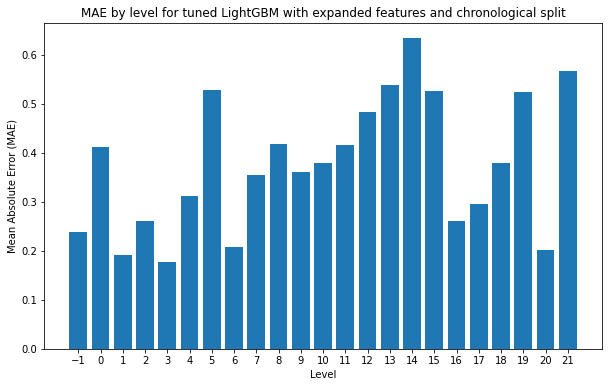

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.47

Round type: round
RMSE: 0.50

Round type: 0.33
RMSE: 0.55

Round type: 0.45
RMSE: 0.51



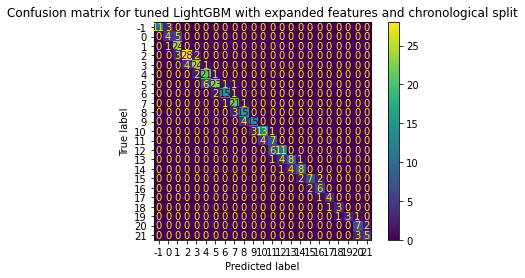

In [29]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with expanded features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l2: 0.148111	valid_0's l1: 0.267273


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.38
MAE: 0.27


In [33]:
results.loc[2] = ["random", "default", "expanded", rmse, mae]

###### MAE by level

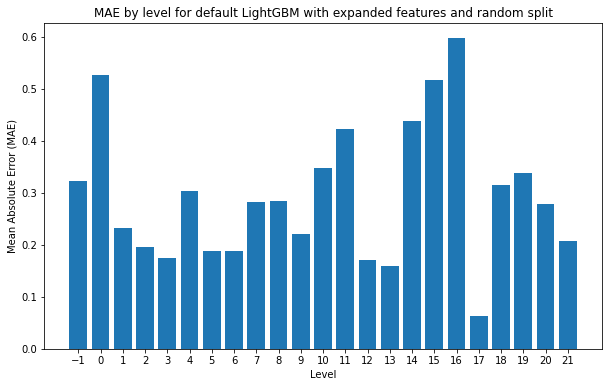

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and random split",
)

In [35]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.38

Round type: round
RMSE: 0.39

Round type: 0.33
RMSE: 0.45

Round type: 0.45
RMSE: 0.41



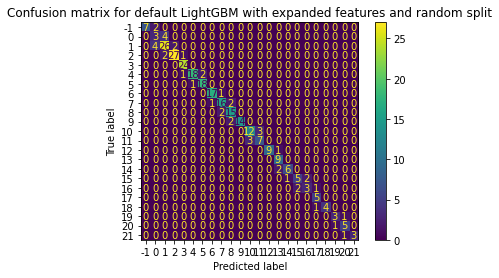

In [36]:
plot_confusion_matrix(
    "round",
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with expanded features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-05 12:42:21,686] A new study created in memory with name: no-name-d0aa95dd-c3c8-4257-83a9-fe8f241a6eac
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.179247 + 0.0488411
[200]	cv_agg's l2: 0.17949 + 0.0446918


feature_fraction, val_score: 0.178105:  14%|######4                                      | 1/7 [00:03<00:20,  3.45s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.178105 + 0.0467388
[100]	cv_agg's l2: 0.194383 + 0.0456547
[200]	cv_agg's l2: 0.191225 + 0.044038


feature_fraction, val_score: 0.178105:  29%|############8                                | 2/7 [00:06<00:17,  3.47s/it]

Early stopping, best iteration is:
[140]	cv_agg's l2: 0.178105 + 0.0467388
[100]	cv_agg's l2: 0.173113 + 0.0469616
[200]	cv_agg's l2: 0.173677 + 0.0468013


feature_fraction, val_score: 0.172209:  43%|###################2                         | 3/7 [00:09<00:12,  3.20s/it]

Early stopping, best iteration is:
[117]	cv_agg's l2: 0.172209 + 0.0476638
[100]	cv_agg's l2: 0.173187 + 0.0167632
[200]	cv_agg's l2: 0.169082 + 0.0143807
[300]	cv_agg's l2: 0.169283 + 0.0140803


feature_fraction, val_score: 0.168604:  57%|#########################7                   | 4/7 [00:14<00:11,  3.67s/it]

Early stopping, best iteration is:
[245]	cv_agg's l2: 0.168604 + 0.0140254
[100]	cv_agg's l2: 0.185471 + 0.0424816
[200]	cv_agg's l2: 0.183982 + 0.0402062
[300]	cv_agg's l2: 0.183483 + 0.0387736


feature_fraction, val_score: 0.168604:  71%|################################1            | 5/7 [00:19<00:08,  4.15s/it]

Early stopping, best iteration is:
[245]	cv_agg's l2: 0.168604 + 0.0140254
[100]	cv_agg's l2: 0.179548 + 0.0517792
[200]	cv_agg's l2: 0.180431 + 0.050677
[300]	cv_agg's l2: 0.181769 + 0.0492885


feature_fraction, val_score: 0.168604:  86%|######################################5      | 6/7 [00:24<00:04,  4.37s/it]

Early stopping, best iteration is:
[245]	cv_agg's l2: 0.168604 + 0.0140254
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821


feature_fraction, val_score: 0.168452: 100%|#############################################| 7/7 [00:28<00:00,  4.03s/it]


[300]	cv_agg's l2: 0.169487 + 0.0437568
Early stopping, best iteration is:
[209]	cv_agg's l2: 0.168452 + 0.0431585


num_leaves, val_score: 0.168452:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.167808 + 0.0467407
[200]	cv_agg's l2: 0.168583 + 0.0434744


num_leaves, val_score: 0.167585:   5%|##5                                               | 1/20 [00:02<00:48,  2.53s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.167585 + 0.0444319
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821


num_leaves, val_score: 0.167585:  10%|#####                                             | 2/20 [00:05<00:53,  2.95s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.167585 + 0.0444319
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821


num_leaves, val_score: 0.167585:  15%|#######5                                          | 3/20 [00:08<00:52,  3.07s/it]

Early stopping, best iteration is:
[136]	cv_agg's l2: 0.167585 + 0.0444319
[100]	cv_agg's l2: 0.16309 + 0.0455647
[200]	cv_agg's l2: 0.161494 + 0.0423926
[300]	cv_agg's l2: 0.161105 + 0.0418645


num_leaves, val_score: 0.160831:  20%|##########                                        | 4/20 [00:11<00:48,  3.02s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.172679 + 0.04361
[200]	cv_agg's l2: 0.168858 + 0.039601
[300]	cv_agg's l2: 0.167387 + 0.0386015


num_leaves, val_score: 0.160831:  25%|############5                                     | 5/20 [00:14<00:41,  2.75s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  30%|###############                                   | 6/20 [00:18<00:46,  3.33s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.305472 + 0.0798045
[200]	cv_agg's l2: 0.269089 + 0.0665938


num_leaves, val_score: 0.160831:  35%|#################5                                | 7/20 [00:19<00:32,  2.47s/it]

[300]	cv_agg's l2: 0.260145 + 0.0615702
Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  40%|####################                              | 8/20 [00:23<00:37,  3.16s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  45%|######################5                           | 9/20 [00:28<00:39,  3.62s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  50%|########################5                        | 10/20 [00:33<00:38,  3.86s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  55%|##########################9                      | 11/20 [00:37<00:36,  4.06s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  60%|#############################4                   | 12/20 [00:41<00:33,  4.14s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169858 + 0.0467705
[200]	cv_agg's l2: 0.170121 + 0.0445163
[300]	cv_agg's l2: 0.17165 + 0.0458179


num_leaves, val_score: 0.160831:  65%|###############################8                 | 13/20 [00:46<00:29,  4.18s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  70%|##################################3              | 14/20 [00:50<00:26,  4.37s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.25074 + 0.0612784
[200]	cv_agg's l2: 0.223391 + 0.0473162


num_leaves, val_score: 0.160831:  75%|####################################7            | 15/20 [00:51<00:16,  3.30s/it]

[300]	cv_agg's l2: 0.208566 + 0.0396484
Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.167817 + 0.0448804
[200]	cv_agg's l2: 0.168227 + 0.0424616
[300]	cv_agg's l2: 0.16922 + 0.0424923


num_leaves, val_score: 0.160831:  80%|#######################################2         | 16/20 [00:56<00:14,  3.62s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  85%|#########################################6       | 17/20 [01:01<00:12,  4.01s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.167808 + 0.0467407
[200]	cv_agg's l2: 0.168583 + 0.0434744
[300]	cv_agg's l2: 0.168933 + 0.0426175


num_leaves, val_score: 0.160831:  90%|############################################1    | 18/20 [01:04<00:07,  3.84s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831:  95%|##############################################5  | 19/20 [01:08<00:03,  3.98s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.169805 + 0.0444351
[200]	cv_agg's l2: 0.168559 + 0.0429821
[300]	cv_agg's l2: 0.169546 + 0.0438734


num_leaves, val_score: 0.160831: 100%|#################################################| 20/20 [01:13<00:00,  3.66s/it]


Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699


bagging, val_score: 0.160831:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.182395 + 0.0424803
[200]	cv_agg's l2: 0.182224 + 0.039664
[300]	cv_agg's l2: 0.182629 + 0.0391694


bagging, val_score: 0.160831:  10%|#####3                                               | 1/10 [00:02<00:26,  2.98s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.1728 + 0.0371057
[200]	cv_agg's l2: 0.170299 + 0.0338727
[300]	cv_agg's l2: 0.171097 + 0.0343893


bagging, val_score: 0.160831:  20%|##########6                                          | 2/10 [00:06<00:25,  3.23s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.209949 + 0.0332162
[200]	cv_agg's l2: 0.203533 + 0.032176
[300]	cv_agg's l2: 0.201656 + 0.0306201


bagging, val_score: 0.160831:  30%|###############9                                     | 3/10 [00:10<00:24,  3.45s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.16309 + 0.0455647
[200]	cv_agg's l2: 0.161494 + 0.0423926
[300]	cv_agg's l2: 0.161105 + 0.0418645


bagging, val_score: 0.160831:  40%|#####################2                               | 4/10 [00:13<00:20,  3.34s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.171272 + 0.0452884
[200]	cv_agg's l2: 0.168511 + 0.041511
[300]	cv_agg's l2: 0.167282 + 0.0394156


bagging, val_score: 0.160831:  50%|##########################5                          | 5/10 [00:16<00:16,  3.27s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.171353 + 0.0466337
[200]	cv_agg's l2: 0.16903 + 0.042489
[300]	cv_agg's l2: 0.167874 + 0.0406402


bagging, val_score: 0.160831:  60%|###############################8                     | 6/10 [00:19<00:12,  3.18s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.167436 + 0.0478317
[200]	cv_agg's l2: 0.165263 + 0.0463892
[300]	cv_agg's l2: 0.165456 + 0.0452509


bagging, val_score: 0.160831:  70%|#####################################                | 7/10 [00:22<00:09,  3.19s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.168941 + 0.0512507
[200]	cv_agg's l2: 0.165379 + 0.0458012
[300]	cv_agg's l2: 0.165193 + 0.0443712


bagging, val_score: 0.160831:  80%|##########################################4          | 8/10 [00:25<00:06,  3.16s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.168878 + 0.0451004
[200]	cv_agg's l2: 0.166807 + 0.0409338
[300]	cv_agg's l2: 0.165609 + 0.0396323


bagging, val_score: 0.160831:  90%|###############################################7     | 9/10 [00:28<00:03,  3.13s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.172064 + 0.0416089
[200]	cv_agg's l2: 0.171234 + 0.0390979
[300]	cv_agg's l2: 0.172952 + 0.0365325


bagging, val_score: 0.160831: 100%|####################################################| 10/10 [00:32<00:00,  3.25s/it]


Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699


feature_fraction_stage2, val_score: 0.160831:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.165994 + 0.0446711
[200]	cv_agg's l2: 0.163344 + 0.0386483
[300]	cv_agg's l2: 0.163719 + 0.0389818


feature_fraction_stage2, val_score: 0.160831:  17%|######3                               | 1/6 [00:02<00:14,  2.81s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.165994 + 0.0446711
[200]	cv_agg's l2: 0.163344 + 0.0386483
[300]	cv_agg's l2: 0.163719 + 0.0389818


feature_fraction_stage2, val_score: 0.160831:  33%|############6                         | 2/6 [00:05<00:09,  2.48s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.16309 + 0.0455647
[200]	cv_agg's l2: 0.161494 + 0.0423926
[300]	cv_agg's l2: 0.161105 + 0.0418645


feature_fraction_stage2, val_score: 0.160831:  50%|###################                   | 3/6 [00:07<00:07,  2.37s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.16309 + 0.0455647
[200]	cv_agg's l2: 0.161494 + 0.0423926
[300]	cv_agg's l2: 0.161105 + 0.0418645


feature_fraction_stage2, val_score: 0.160831:  67%|#########################3            | 4/6 [00:09<00:04,  2.21s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.171525 + 0.0460685
[200]	cv_agg's l2: 0.168619 + 0.0437372
[300]	cv_agg's l2: 0.168165 + 0.0436434


feature_fraction_stage2, val_score: 0.160831:  83%|###############################6      | 5/6 [00:11<00:02,  2.12s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.16309 + 0.0455647
[200]	cv_agg's l2: 0.161494 + 0.0423926
[300]	cv_agg's l2: 0.161105 + 0.0418645


feature_fraction_stage2, val_score: 0.160831: 100%|######################################| 6/6 [00:13<00:00,  2.20s/it]


Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699


regularization_factors, val_score: 0.160831:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.168012 + 0.045149
[200]	cv_agg's l2: 0.165274 + 0.0407654
[300]	cv_agg's l2: 0.16483 + 0.0395251


regularization_factors, val_score: 0.160831:   5%|#9                                    | 1/20 [00:02<00:38,  2.04s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.16309 + 0.0455647
[200]	cv_agg's l2: 0.161516 + 0.0423851
[300]	cv_agg's l2: 0.161434 + 0.0417608


regularization_factors, val_score: 0.160831:  10%|###8                                  | 2/20 [00:04<00:37,  2.07s/it]

Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.219043 + 0.0506414
[200]	cv_agg's l2: 0.215735 + 0.0499271


regularization_factors, val_score: 0.160831:  15%|#####7                                | 3/20 [00:04<00:25,  1.49s/it]

[300]	cv_agg's l2: 0.215733 + 0.0499277
Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699
[100]	cv_agg's l2: 0.16309 + 0.0455647
[200]	cv_agg's l2: 0.161516 + 0.0423851
[300]	cv_agg's l2: 0.161434 + 0.0417608
Early stopping, best iteration is:
[240]	cv_agg's l2: 0.160831 + 0.0421699


regularization_factors, val_score: 0.160831:  20%|#######6                              | 4/20 [00:06<00:27,  1.70s/it]

[100]	cv_agg's l2: 0.161766 + 0.0450704
[200]	cv_agg's l2: 0.160101 + 0.0420264
[300]	cv_agg's l2: 0.160949 + 0.0431017


regularization_factors, val_score: 0.159589:  25%|#########5                            | 5/20 [00:08<00:27,  1.82s/it]

Early stopping, best iteration is:
[246]	cv_agg's l2: 0.159589 + 0.0424796
[100]	cv_agg's l2: 0.163214 + 0.0445605
[200]	cv_agg's l2: 0.161417 + 0.0413698
[300]	cv_agg's l2: 0.162703 + 0.042358


regularization_factors, val_score: 0.159589:  30%|###########4                          | 6/20 [00:11<00:27,  1.94s/it]

Early stopping, best iteration is:
[246]	cv_agg's l2: 0.159589 + 0.0424796
[100]	cv_agg's l2: 0.16283 + 0.0447764
[200]	cv_agg's l2: 0.160303 + 0.0424174
[300]	cv_agg's l2: 0.161163 + 0.0423242


regularization_factors, val_score: 0.159589:  35%|#############3                        | 7/20 [00:13<00:25,  1.98s/it]

Early stopping, best iteration is:
[246]	cv_agg's l2: 0.159589 + 0.0424796
[100]	cv_agg's l2: 0.161617 + 0.0451996
[200]	cv_agg's l2: 0.159839 + 0.0426715
[300]	cv_agg's l2: 0.160038 + 0.0430016


regularization_factors, val_score: 0.158935:  40%|###############2                      | 8/20 [00:15<00:24,  2.03s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.04285
[100]	cv_agg's l2: 0.162838 + 0.0447734
[200]	cv_agg's l2: 0.161153 + 0.0419986
[300]	cv_agg's l2: 0.162183 + 0.0417458


regularization_factors, val_score: 0.158935:  45%|#################1                    | 9/20 [00:17<00:22,  2.03s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.04285
[100]	cv_agg's l2: 0.161617 + 0.0451998
[200]	cv_agg's l2: 0.159839 + 0.0426716
[300]	cv_agg's l2: 0.160038 + 0.0430018


regularization_factors, val_score: 0.158935:  50%|##################5                  | 10/20 [00:19<00:20,  2.05s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.04285
[100]	cv_agg's l2: 0.161617 + 0.0451997
[200]	cv_agg's l2: 0.159839 + 0.0426716
[300]	cv_agg's l2: 0.160359 + 0.0429292


regularization_factors, val_score: 0.158935:  55%|####################3                | 11/20 [00:21<00:18,  2.02s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.16283 + 0.044776
[200]	cv_agg's l2: 0.160303 + 0.042417
[300]	cv_agg's l2: 0.161162 + 0.0423239


regularization_factors, val_score: 0.158935:  60%|######################2              | 12/20 [00:23<00:16,  2.02s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.162838 + 0.0447733
[200]	cv_agg's l2: 0.161153 + 0.0419986
[300]	cv_agg's l2: 0.161962 + 0.0419417


regularization_factors, val_score: 0.158935:  65%|########################             | 13/20 [00:25<00:13,  2.00s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.161617 + 0.0451997
[200]	cv_agg's l2: 0.159839 + 0.0426716
[300]	cv_agg's l2: 0.160038 + 0.0430017


regularization_factors, val_score: 0.158935:  70%|#########################9           | 14/20 [00:27<00:11,  1.99s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.162684 + 0.0447428
[200]	cv_agg's l2: 0.161117 + 0.0421961
[300]	cv_agg's l2: 0.162418 + 0.0429864


regularization_factors, val_score: 0.158935:  75%|###########################7         | 15/20 [00:29<00:09,  1.98s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.165463 + 0.0467849
[200]	cv_agg's l2: 0.16321 + 0.043442
[300]	cv_agg's l2: 0.163383 + 0.0441358


regularization_factors, val_score: 0.158935:  80%|#############################6       | 16/20 [00:31<00:07,  1.99s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.16283 + 0.0447773
[200]	cv_agg's l2: 0.160458 + 0.0423796
[300]	cv_agg's l2: 0.161232 + 0.0427168


regularization_factors, val_score: 0.158935:  85%|###############################4     | 17/20 [00:33<00:05,  1.98s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.167166 + 0.0419901
[200]	cv_agg's l2: 0.163566 + 0.0390955
[300]	cv_agg's l2: 0.164892 + 0.0378069


regularization_factors, val_score: 0.158935:  90%|#################################3   | 18/20 [00:35<00:04,  2.01s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.16283 + 0.0447771
[200]	cv_agg's l2: 0.160546 + 0.0423438
[300]	cv_agg's l2: 0.161378 + 0.0426398


regularization_factors, val_score: 0.158935:  95%|###################################1 | 19/20 [00:37<00:02,  2.02s/it]

Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.162979 + 0.0446422
[200]	cv_agg's l2: 0.161021 + 0.0418993
[300]	cv_agg's l2: 0.161757 + 0.0425888


regularization_factors, val_score: 0.158935: 100%|#####################################| 20/20 [00:39<00:00,  1.97s/it]


Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501


min_data_in_leaf, val_score: 0.158935:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.668251 + 0.044344
[200]	cv_agg's l2: 0.63353 + 0.0490032


min_data_in_leaf, val_score: 0.158935:  20%|#########                                    | 1/5 [00:00<00:03,  1.04it/s]

[300]	cv_agg's l2: 0.617071 + 0.0528322
Early stopping, best iteration is:
[243]	cv_agg's l2: 0.158935 + 0.0428501
[100]	cv_agg's l2: 0.158031 + 0.0431286
[200]	cv_agg's l2: 0.153582 + 0.0408148
[300]	cv_agg's l2: 0.152851 + 0.0391415
[400]	cv_agg's l2: 0.151948 + 0.0380735
[500]	cv_agg's l2: 0.151616 + 0.0377432
[600]	cv_agg's l2: 0.151553 + 0.0373442


min_data_in_leaf, val_score: 0.151472:  40%|##################                           | 2/5 [00:05<00:08,  2.81s/it]

Early stopping, best iteration is:
[587]	cv_agg's l2: 0.151472 + 0.0373382
[100]	cv_agg's l2: 0.178781 + 0.0444995
[200]	cv_agg's l2: 0.174269 + 0.0414966
[300]	cv_agg's l2: 0.174658 + 0.0411564
[400]	cv_agg's l2: 0.174949 + 0.0415011
[500]	cv_agg's l2: 0.175138 + 0.04152
[600]	cv_agg's l2: 0.175716 + 0.0412748


min_data_in_leaf, val_score: 0.151472:  60%|###########################                  | 3/5 [00:09<00:06,  3.37s/it]

Early stopping, best iteration is:
[587]	cv_agg's l2: 0.151472 + 0.0373382
[100]	cv_agg's l2: 0.159495 + 0.0431407
[200]	cv_agg's l2: 0.154768 + 0.0390815
[300]	cv_agg's l2: 0.152194 + 0.0380226
[400]	cv_agg's l2: 0.151598 + 0.0364424
[500]	cv_agg's l2: 0.151594 + 0.0363166
[600]	cv_agg's l2: 0.151885 + 0.0359553


min_data_in_leaf, val_score: 0.151472:  80%|####################################         | 4/5 [00:12<00:03,  3.56s/it]

Early stopping, best iteration is:
[587]	cv_agg's l2: 0.151472 + 0.0373382
[100]	cv_agg's l2: 0.233498 + 0.0455353
[200]	cv_agg's l2: 0.224848 + 0.043701
[300]	cv_agg's l2: 0.220442 + 0.0432703
[400]	cv_agg's l2: 0.218967 + 0.0424074
[500]	cv_agg's l2: 0.216838 + 0.04279
[600]	cv_agg's l2: 0.216621 + 0.0422909


min_data_in_leaf, val_score: 0.151472: 100%|#############################################| 5/5 [00:16<00:00,  3.23s/it]

Early stopping, best iteration is:
[587]	cv_agg's l2: 0.151472 + 0.0373382


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.15147242780087353
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 2.09470933157928e-05
    lambda_l2: 0.0025989819125871207
    num_leaves: 15
    feature_fraction: 0.6
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.36
MAE test: 0.24



In [41]:
results.loc[3] = ["random", "Optuna", "expanded", rmse, mae]

###### MAE by level

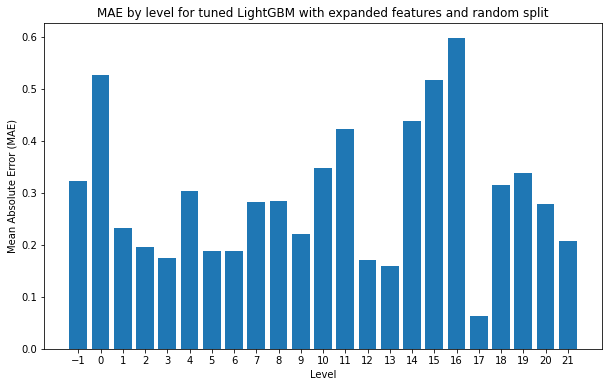

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.22

Round type: round
RMSE: 0.25

Round type: 0.33
RMSE: 0.25

Round type: 0.45
RMSE: 0.24



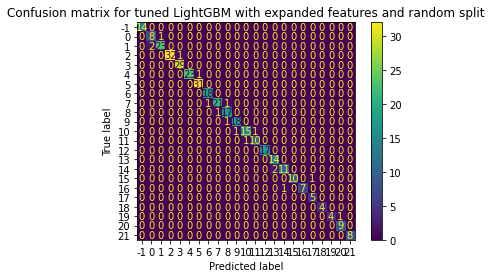

In [44]:
plot_confusion_matrix(
    "round",
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with expanded features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,expanded,0.510772,0.357206
1,chronological,Optuna,expanded,0.466000,0.338290
2,random,default,expanded,0.384853,0.267273
3,random,Optuna,expanded,0.360392,0.236889


In [46]:
from training.results import plot_summary

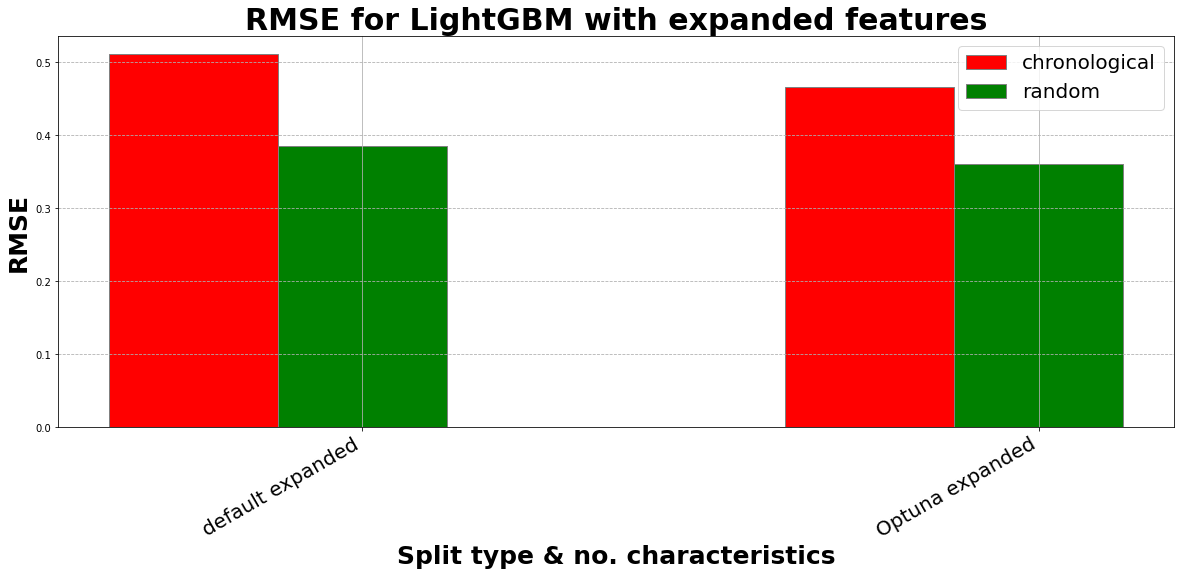

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with expanded features")

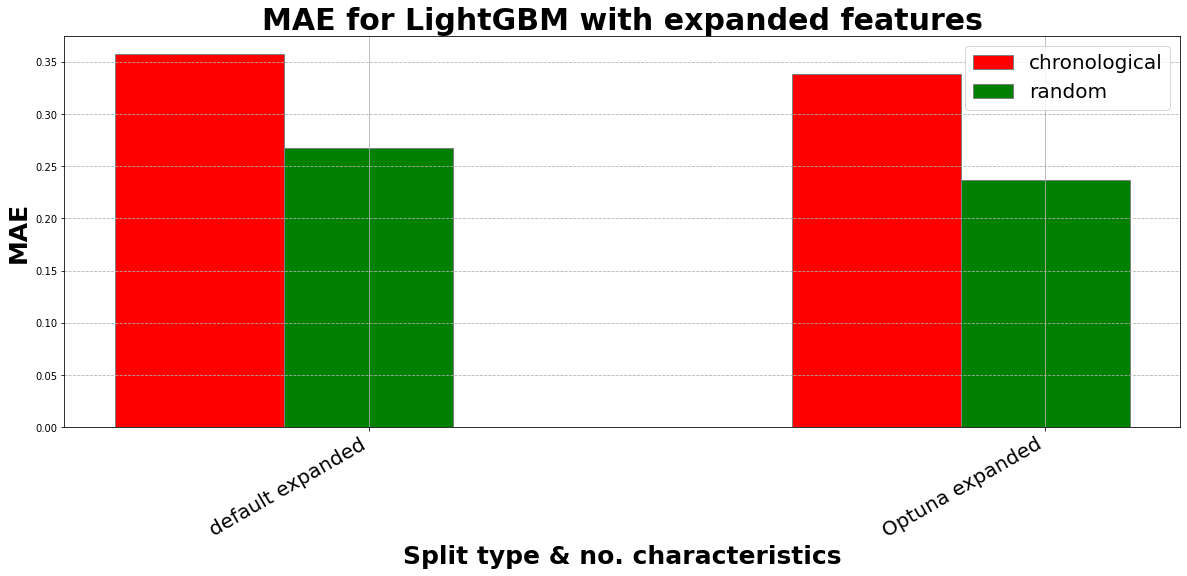

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with expanded features")

In [49]:
results.to_json("./lightgbm_expanded_results.json", indent=2)